# Introduction

In recent years, we are evident of several changes in the music industry. Some of these changes can be associated with the consumers, as the magnitude and platforms of consumption grew. At the same time, innovations on behalf of the artists led to new genres of music to arise. One outcome of said changes is the rising presence of explicit lyrical content within the songwriting process, and the large exposure to it , especially of the youth.

Thus, in the scope of this project, we wanted to test whether having explicit lyrics has any considerable effect on the popularity of the song.

Hence, we can formulate the following question: "Does the presence of explicit content in a song's lyrics increase its popularity?".

## Explicit Content  

Regarding the definition of "explicit lyrical content", there is no general consensus. Obviously, culture has a major effect on the matter, with lots of considerations about the intended audience and the listening context.

As of today, the decision regarding the presence of explicit content in songs lyrics is done mostly by humans. This can be done by either the rights-holders of the song who inform the different platforms (Spotify, YouTube etc.), or by user based flagging when consuming the content.

## Songs Popularity

Generally speaking, the popularity of a song can be measured by the amount of times it has been listened to by the public. One key observation to make is the rise of different platforms one can use to listen to music. 

In the beggining-middle of the 20th century, the main platforms were the radio and sales of physical copies of songs, where as today we have online streaming platforms and apps. Since 1958, the "Billboard Hot 100" weekly chart has been considered by many as the concensus for most popular songs. 

These days, these chart rankings approximate weighting is 35-45% for sales, 30-40% for airplay, and 20-30% for streaming. An annual "year end" chart is also released, ranking that year's songs by calculating a cumulative total of sales, airplay, and streaming


We believe our research will show that explicit content has a positive effect on the popularity of a given song. I.e., a song which contains explicit lyrical content will have a higher chance of being popular. 
<font color='red'>Add why we believe this is the case</font>

## Add short paragraph about the evolution of msic streaming? This can expllain several phenomenans in the data


# Data

In this project, we will use the following [data](https://www.kaggle.com/datasets/ektanegi/spotifydata-19212020).
This data-set contains approximately 169,000 songs from Spotify, spanning between 1921 and 2020. For each year, the top 100 songs - according to spotify - were recorded.

For each song, we have several types of features such as song charactaristic (e.g., tempo and danceability), and general information regarding the song (e.g., artist name, published year and song name).

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data/spotify1921-2020.csv')
df

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.9950,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563000,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.9940,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901000,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.6040,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.9950,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887000,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.9900,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908000,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169904,0.1730,"['DripReport', 'Tyga']",0.875,163800,0.4430,1,4KppkflX7I3vJQk7urOJaS,0.000032,1,0.0891,-7.461,1,Skechers (feat. Tyga) - Remix,75,2020-05-15,0.1430,100.012,0.3060,2020
169905,0.0167,"['Leon Bridges', 'Terrace Martin']",0.719,167468,0.3850,0,1ehhGlTvjtHo2e4xJFB0SZ,0.031300,8,0.1110,-10.907,1,Sweeter (feat. Terrace Martin),64,2020-06-08,0.0403,128.000,0.2700,2020
169906,0.5380,"['Kygo', 'Oh Wonder']",0.514,180700,0.5390,0,52eycxprLhK3lPcRLbQiVk,0.002330,7,0.1080,-9.332,1,How Would I Know,70,2020-05-29,0.1050,123.700,0.1530,2020
169907,0.0714,"['Cash Cash', 'Andy Grammer']",0.646,167308,0.7610,0,3wYOGJYD31sLRmBgCvWxa4,0.000000,1,0.2220,-2.557,1,I Found You,70,2020-02-28,0.0385,129.916,0.4720,2020


## Defining the Treatment and Effect

As per our causal question formulation, the treatment and effect are the 'explicit ' and 'popularity' columns of the data respectivally.

The popularity column is Spotify's popularity rating index, which ranges from 0-100.
The explicit column is Spotify's explicit content flag, ehich is binary (0 = No explicit content, 1 = Explicit content)

As for this point forward, these columns will be reffered as treatment and effect. 

In [3]:
# we mark our treatment as the "explicit" column and our effect as the popularity column
# (treatment is binary and popularity ranges from 0 to 100)
df = df.rename(columns={'explicit': 'treatment', 'popularity': 'effect'})
df

,acousticness,artists,danceability,duration_ms,energy,treatment,id,instrumentalness,key,liveness,loudness,mode,name,effect,release_date,speechiness,tempo,valence,year
0,0.9950,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563000,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.9940,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901000,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.6040,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.9950,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887000,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.9900,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908000,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169904,0.1730,"['DripReport', 'Tyga']",0.875,163800,0.4430,1,4KppkflX7I3vJQk7urOJaS,0.000032,1,0.0891,-7.461,1,Skechers (feat. Tyga) - Remix,75,2020-05-15,0.1430,100.012,0.3060,2020
169905,0.0167,"['Leon Bridges', 'Terrace Martin']",0.719,167468,0.3850,0,1ehhGlTvjtHo2e4xJFB0SZ,0.031300,8,0.1110,-10.907,1,Sweeter (feat. Terrace Martin),64,2020-06-08,0.0403,128.000,0.2700,2020
169906,0.5380,"['Kygo', 'Oh Wonder']",0.514,180700,0.5390,0,52eycxprLhK3lPcRLbQiVk,0.002330,7,0.1080,-9.332,1,How Would I Know,70,2020-05-29,0.1050,123.700,0.1530,2020
169907,0.0714,"['Cash Cash', 'Andy Grammer']",0.646,167308,0.7610,0,3wYOGJYD31sLRmBgCvWxa4,0.000000,1,0.2220,-2.557,1,I Found You,70,2020-02-28,0.0385,129.916,0.4720,2020


## Data Preprocessing

In this section, we removed columns which were irrelevant for our research question.
Firstly, we removed the 'id' as it is only an identifier for a record, and has no influence.
Moreover, since the song name doesnt effect neither the popularity nor the presence of explicit content in the lyrics, it was removed as well.  We also removed the full release date feature, as we were only interested in the year of publishing, which was an individual feature present in the data. The month and day were not as important.

In [4]:
# we remove the release_date column as its format is not consistent across all records
# some records have the complete date, some have the year only - we take the year only
df = df.drop(columns=['release_date'])
# we remove id, song name and artist name as they are not useful for our analysis
df = df.drop(columns=['id', 'name'])
df

,acousticness,artists,danceability,duration_ms,energy,treatment,instrumentalness,key,liveness,loudness,mode,effect,speechiness,tempo,valence,year
0,0.9950,['Carl Woitschach'],0.708,158648,0.1950,0,0.563000,10,0.1510,-12.428,1,0,0.0506,118.469,0.7790,1928
1,0.9940,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,0.901000,8,0.0763,-28.454,1,0,0.0462,83.972,0.0767,1928
2,0.6040,['Seweryn Goszczyński'],0.749,104300,0.2200,0,0.000000,5,0.1190,-19.924,0,0,0.9290,107.177,0.8800,1928
3,0.9950,['Francisco Canaro'],0.781,180760,0.1300,0,0.887000,1,0.1110,-14.734,0,0,0.0926,108.003,0.7200,1928
4,0.9900,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,0.908000,11,0.0980,-16.829,1,1,0.0424,62.149,0.0693,1928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169904,0.1730,"['DripReport', 'Tyga']",0.875,163800,0.4430,1,0.000032,1,0.0891,-7.461,1,75,0.1430,100.012,0.3060,2020
169905,0.0167,"['Leon Bridges', 'Terrace Martin']",0.719,167468,0.3850,0,0.031300,8,0.1110,-10.907,1,64,0.0403,128.000,0.2700,2020
169906,0.5380,"['Kygo', 'Oh Wonder']",0.514,180700,0.5390,0,0.002330,7,0.1080,-9.332,1,70,0.1050,123.700,0.1530,2020
169907,0.0714,"['Cash Cash', 'Andy Grammer']",0.646,167308,0.7610,0,0.000000,1,0.2220,-2.557,1,70,0.0385,129.916,0.4720,2020


## Data Transformation

As to the artists of the song, we believe that it has an effect on both the potential presence of explicit lyrics in the song, and on the potential populrity of a song.
Usually, an artist has a signature style of music, which can be characarized with the presence of explicit lyrics - such as rap and hip-hop. In addition, an artist can enjoy the attention of the public, and can gain interest about a future song, even before publishing it. Thus, we need to find a way to endoce the artist into the data , as it is a confounding element in our opinion.

Yet, there are several thousands different artist, so a plain one-hot encoding was not applicable.
Our solution to this problem is as follows: firstly, we used only the main artist of every song (in the case of collaborations), and for every song, we estimated the popularity and tendency to explicit content by averaging those parameters across past songs of the main artist.

This transformation of the treatment (explicit content) can be thought of as calculating the probability of an artist to write a song with explicit content, when writing the current song. Similarily, the transformation of the effect (popularity) can be seen as the estimated potential interest of the public for the artist's new song.

In [5]:
# to extract information from the artists column, without having to add a one-hot encoding for each artist (4000+)
# we will instead, try to extract a "popularity" and "explicitness" for each song based on the artists that are associated with it
# we will do this by taking the average popularity and explicit of all the previous songs from the artists that are associated with it
# we take only the first artist as the main artist
df['artists'] = df['artists'].apply(lambda x: x[0])
df = df.sort_values(by=['artists', 'year'])
# 2234 is the max amount of songs by an artist
df['previous_artist_explicitness'] = df.groupby('artists')['treatment'].transform(lambda x: x.shift(1).rolling(2234, min_periods=1).mean()).fillna(0)
df['previous_artist_popularity'] = df.groupby('artists')['effect'].transform(lambda x: x.shift(1).rolling(2234, min_periods=1).mean()).fillna(0)
df = df.drop(columns=['artists'])
df

,acousticness,danceability,duration_ms,energy,treatment,instrumentalness,key,liveness,loudness,mode,effect,speechiness,tempo,valence,year,previous_artist_explicitness,previous_artist_popularity
78068,0.7320,0.819,180533,0.341,0,0.000000,7,0.1600,-12.441,1,7,0.4150,60.936,0.9630,1921,0.000000,0.000000
78069,0.9820,0.279,831667,0.211,0,0.878000,10,0.6650,-20.096,1,5,0.0366,80.954,0.0594,1921,0.000000,7.000000
78070,0.9410,0.241,196307,0.274,0,0.000008,0,0.0984,-9.750,0,2,0.0297,90.773,0.2120,1921,0.000000,6.000000
78071,0.9570,0.418,166693,0.193,0,0.000002,3,0.2290,-10.096,1,2,0.0380,101.665,0.2530,1921,0.000000,4.666667
78072,0.9960,0.518,159507,0.203,0,0.000000,0,0.1150,-10.589,1,5,0.0615,66.221,0.4060,1921,0.000000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169904,0.1730,0.875,163800,0.443,1,0.000032,1,0.0891,-7.461,1,75,0.1430,100.012,0.3060,2020,0.478514,64.578335
169905,0.0167,0.719,167468,0.385,0,0.031300,8,0.1110,-10.907,1,64,0.0403,128.000,0.2700,2020,0.478514,64.580573
169906,0.5380,0.514,180700,0.539,0,0.002330,7,0.1080,-9.332,1,70,0.1050,123.700,0.1530,2020,0.478514,64.576097
169907,0.0714,0.646,167308,0.761,0,0.000000,1,0.2220,-2.557,1,70,0.0385,129.916,0.4720,2020,0.478514,64.575649


In [6]:
# reorder all the columns
df = pd.concat([df.loc[:, ~df.columns.isin(['treatment', 'effect'])], df.loc[:, ['treatment', 'effect']]], axis=1)
df

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,year,previous_artist_explicitness,previous_artist_popularity,treatment,effect
78068,0.7320,0.819,180533,0.341,0.000000,7,0.1600,-12.441,1,0.4150,60.936,0.9630,1921,0.000000,0.000000,0,7
78069,0.9820,0.279,831667,0.211,0.878000,10,0.6650,-20.096,1,0.0366,80.954,0.0594,1921,0.000000,7.000000,0,5
78070,0.9410,0.241,196307,0.274,0.000008,0,0.0984,-9.750,0,0.0297,90.773,0.2120,1921,0.000000,6.000000,0,2
78071,0.9570,0.418,166693,0.193,0.000002,3,0.2290,-10.096,1,0.0380,101.665,0.2530,1921,0.000000,4.666667,0,2
78072,0.9960,0.518,159507,0.203,0.000000,0,0.1150,-10.589,1,0.0615,66.221,0.4060,1921,0.000000,4.000000,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169904,0.1730,0.875,163800,0.443,0.000032,1,0.0891,-7.461,1,0.1430,100.012,0.3060,2020,0.478514,64.578335,1,75
169905,0.0167,0.719,167468,0.385,0.031300,8,0.1110,-10.907,1,0.0403,128.000,0.2700,2020,0.478514,64.580573,0,64
169906,0.5380,0.514,180700,0.539,0.002330,7,0.1080,-9.332,1,0.1050,123.700,0.1530,2020,0.478514,64.576097,0,70
169907,0.0714,0.646,167308,0.761,0.000000,1,0.2220,-2.557,1,0.0385,129.916,0.4720,2020,0.478514,64.575649,0,70


After all the transformation and pre-processing, the main features we will use in the project are:
- Acousticness (Ranges from 0 to 1)
- danceability (Ranges from 0 to 1)
- duration_ms (Integer typically ranging from 200k to 300k)
- energy (Ranges from 0 to 1)
- instrumentalness (Ranges from 0 to 1)
- key (All keys on octave encoded as values ranging from 0 to 11, starting on C as 0, C# as 1 and so on…)
- liveness (Ranges from 0 to 1)
- loudness (Ranges from 0 to 1)
- mode (0 = Minor, 1 = Major)
- speechiness (Ranges from 0 to 1)
- tempo (Float typically ranging from 50 to 150)
- valence (Ranges from 0 to 1)
- year (Ranges from 1921 to 2020)
- treatment (0 = No explicit content, 1 = Explicit content)
- effect (Ranges from 0 to 100)
- previous_artist_explicitness (As explaine dprevously)
- previous_artist_popularity (As explaine dprevously)

# Data Analysis and Statistics

In [7]:
df.describe(percentiles=[]).iloc[1:]

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,year,previous_artist_explicitness,previous_artist_popularity,treatment,effect
mean,0.493214,0.538150,2.314062e+05,0.488593,0.161937,5.200519,0.206690,-11.370289,0.708556,0.094058,116.948017,0.532095,1977.223231,0.081897,31.148843,0.084863,31.556610
std,0.376627,0.175346,1.213219e+05,0.267390,0.309329,3.515257,0.176796,5.666765,0.454429,0.149937,30.726937,0.262408,25.593168,0.104377,19.515174,0.278679,21.582614
min,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,1921.000000,0.000000,0.000000,0.000000,0.000000
50%,0.492000,0.548000,2.086000e+05,0.481000,0.000204,5.000000,0.135000,-10.474000,1.000000,0.045000,114.778000,0.544000,1978.000000,0.027305,35.320054,0.000000,33.000000
max,0.996000,0.988000,5.403500e+06,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,0.969000,244.091000,1.000000,2020.000000,0.483438,69.754700,1.000000,100.000000



<font color='red'>loudness columns is very weird. It is not in the range of (0,1) as the data description in kaggle says. It has negative values.
What to do with it?</font>

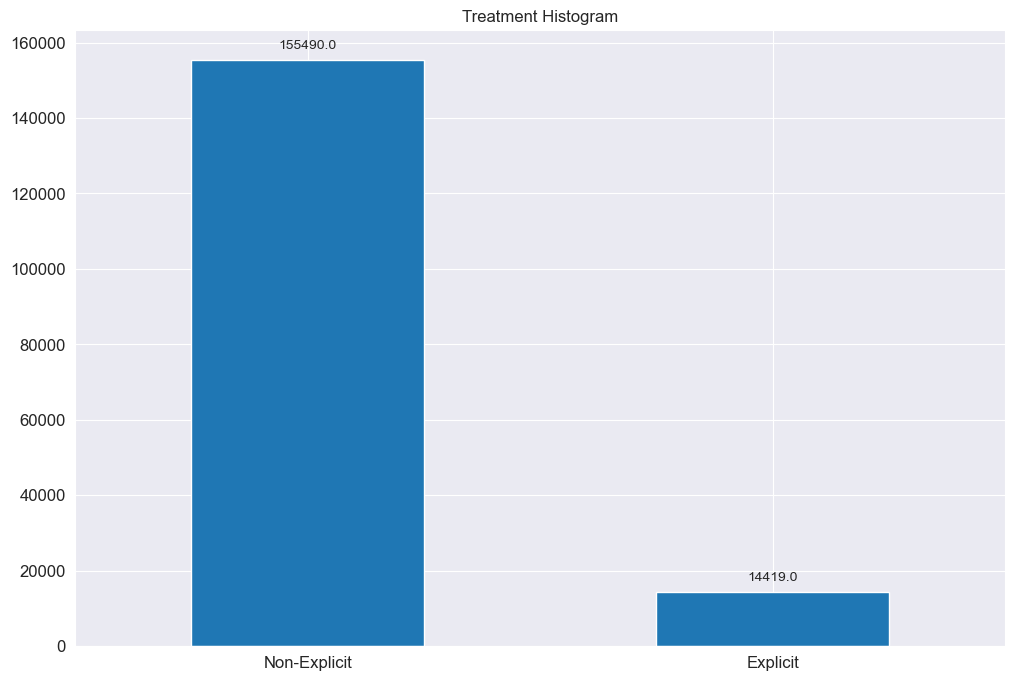

In [8]:
import matplotlib.pyplot as plt
# plot histogram of treatment column
_, ax = plt.subplots(figsize=(12, 8))
df['treatment'].value_counts().plot(kind='bar', title='Treatment Histogram', figsize=(12, 8), fontsize=12, ax=ax)
plt.xticks(rotation=0)
ax.set_xticklabels(['Non-Explicit', 'Explicit'])
# add values to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

First of all, we can see that the treatment distribution in the data-set is highly imbalanced. Roughly 8.5% of the songs are labeled as containing explicit content, while the rest are labeled the opposite.
Whilst this imbalance is not ideal, we still have sufficient records for both categories, thus not harming our potential conclusions. Nevertheless, we will adress this imbalance where neccesary.

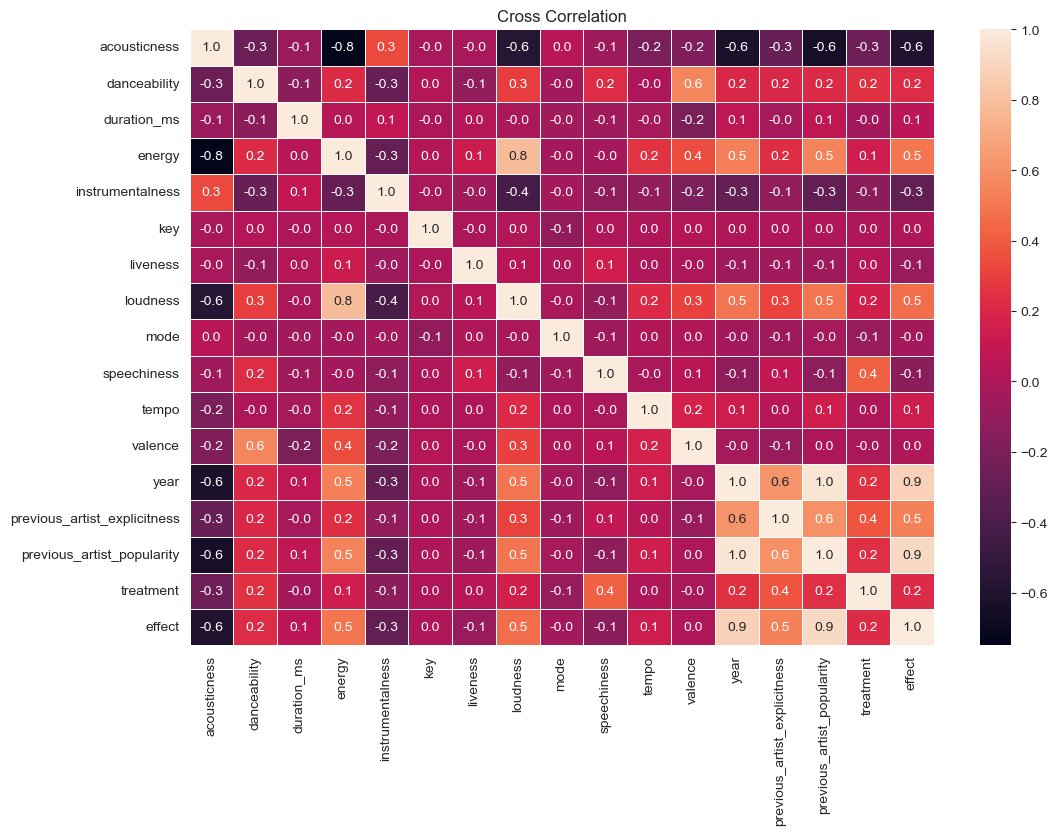

In [9]:
# cross correlation between our features, the treatment and the effect
# plot as matplotlib heatmap
import matplotlib.pyplot as plt
import seaborn as sns
_, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt='.1f', ax=ax)
ax.title.set_text('Cross Correlation')
plt.show()

C:\Users\naorh\AppData\Local\Temp\ipykernel_16004\2970698474.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


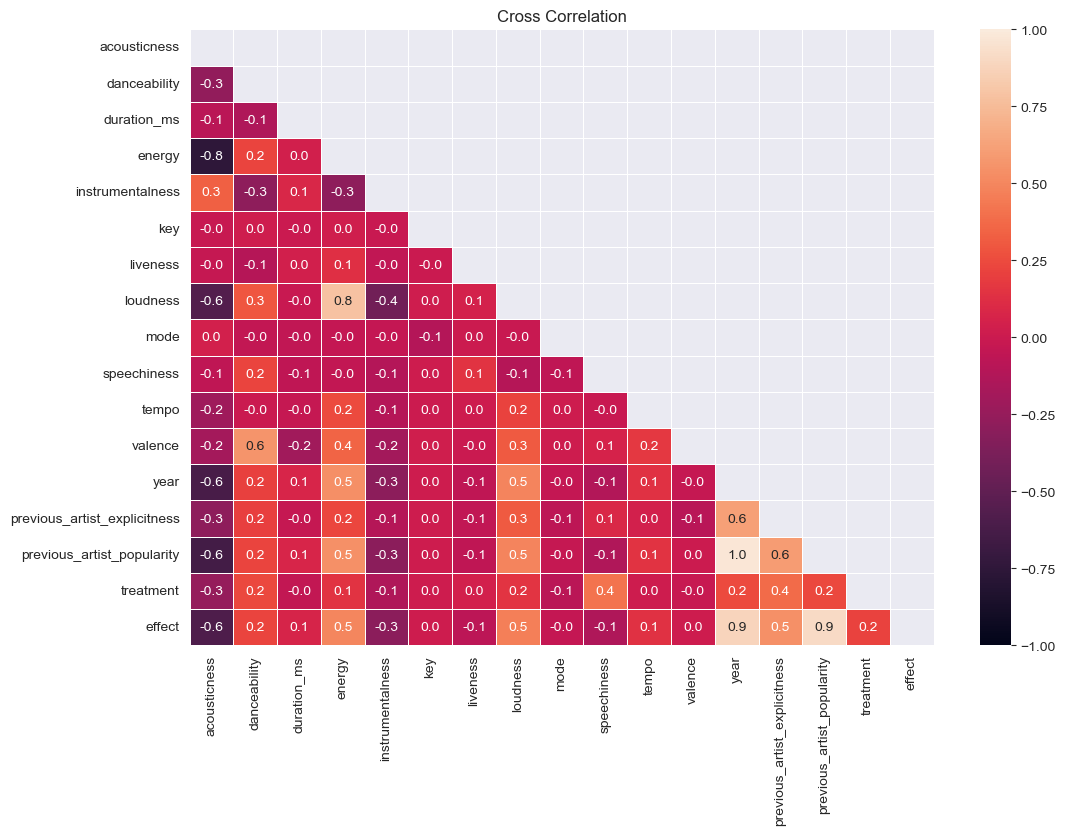

In [10]:
# option 2 for correlation
# cross correlation between our features, the treatment and the effect
# plot as matplotlib heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
_, ax = plt.subplots(figsize=(12, 8))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
heatmap = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True,linewidths=.5, fmt='.1f')
ax.title.set_text('Cross Correlation')
plt.show()

From the chart above we can see that the treatment feature, which represents the presence of explicit content in the song, is somewhat correlated to only two features - speechiness of the song and the artist's previous explicitness. This result shouldnt come as a surprise, as the more words the song has the higher the probability it has to include explicit content. Likewise, the more explicit content an artist has in previous songs, the more likely he is to include it in a future song. 

Furthermore, we can see that the effect is highly positively-correlated with the publishing year of the song, which is logical. The increase of music listening platforms and their accecability, allows for further exposure for music in the last decades. 

<font color='red'>Assume that data from early years is not so well documented</font> 

We can also see that features like energy and loudness are somewhat positively correlated with the effect, and that accousticness is has the opposite trend. 

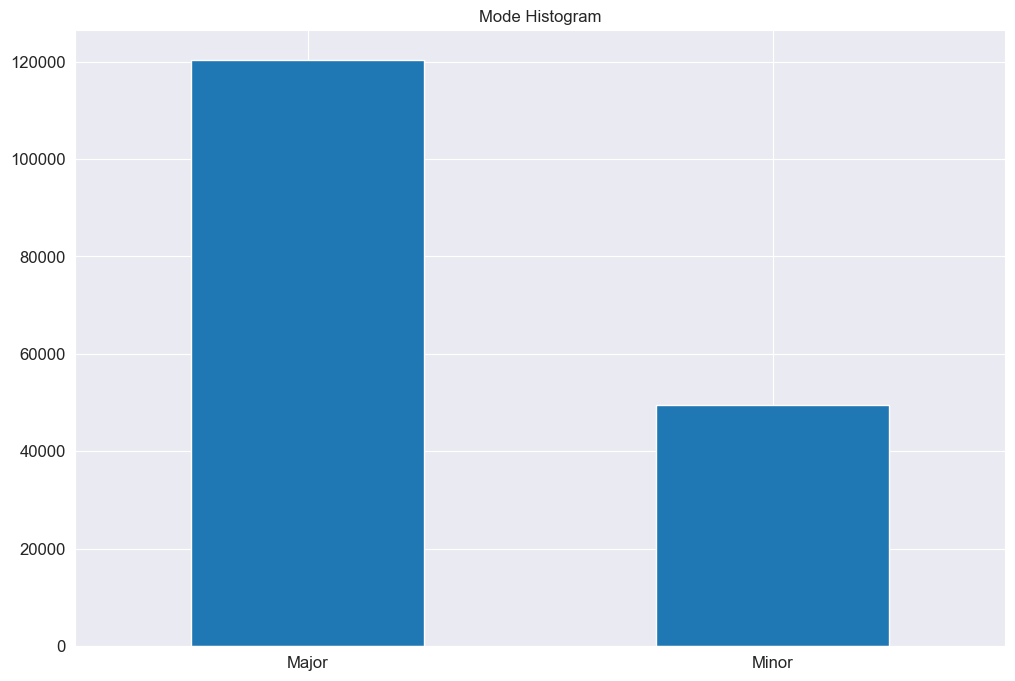

In [11]:
# plot histogram of mode column
_, ax = plt.subplots(figsize=(14, 10))
df['mode'].value_counts().plot(kind='bar', title='Mode Histogram', figsize=(12, 8), fontsize=12, ax=ax)
plt.xticks(rotation=0)
ax.set_xticklabels(['Major', 'Minor'])
plt.show()

As we can see, the mode is mostly major <font color='red'>So What??????</font> 

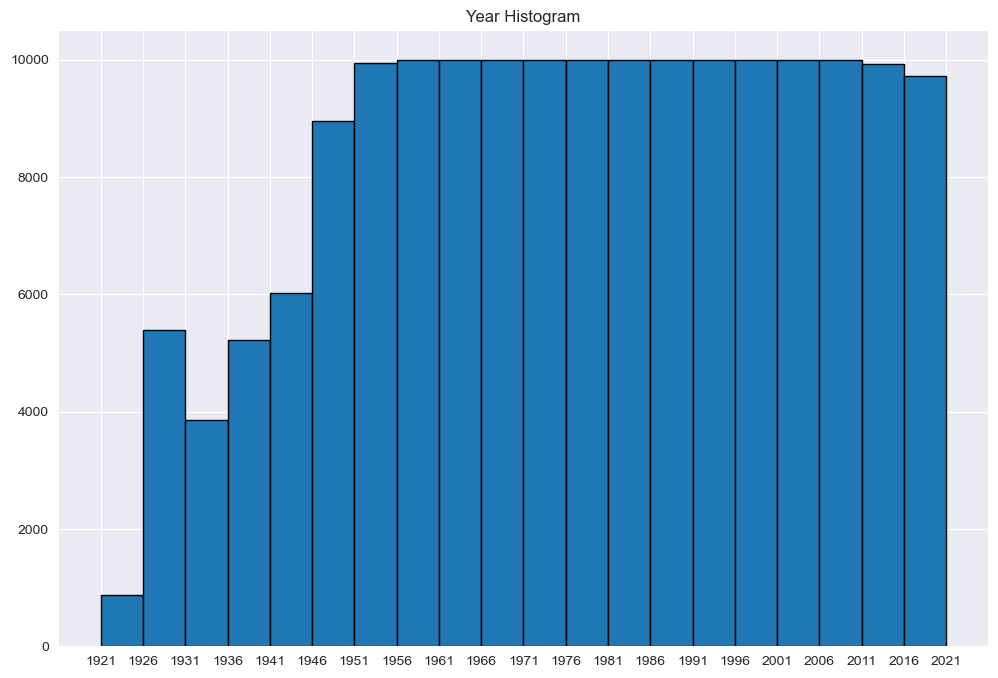

In [12]:
# plot histogram of year column
_, ax = plt.subplots(figsize=(12, 8))
bins = list(range(1921, 2022, 5))
plt.hist(df.year.values, bins=bins, edgecolor="k")
plt.xticks(bins)
ax.title.set_text('Year Histogram')
plt.show()

The amount of records per year is capped at 2,000 (data includes top 2000 songs of each year)
As we can see, early years have a lower number of records, and also the last 10 years has little less records (the difference is not significant)

The large difference between the 2000 recored value to the values of the yers prior to 1950 could be explained by the growth of music  streaming & listening platforms. The rise of record stores, personal consumption formats and most recently online streaming platforms, allowed for beter estimation of the popularity of songs.

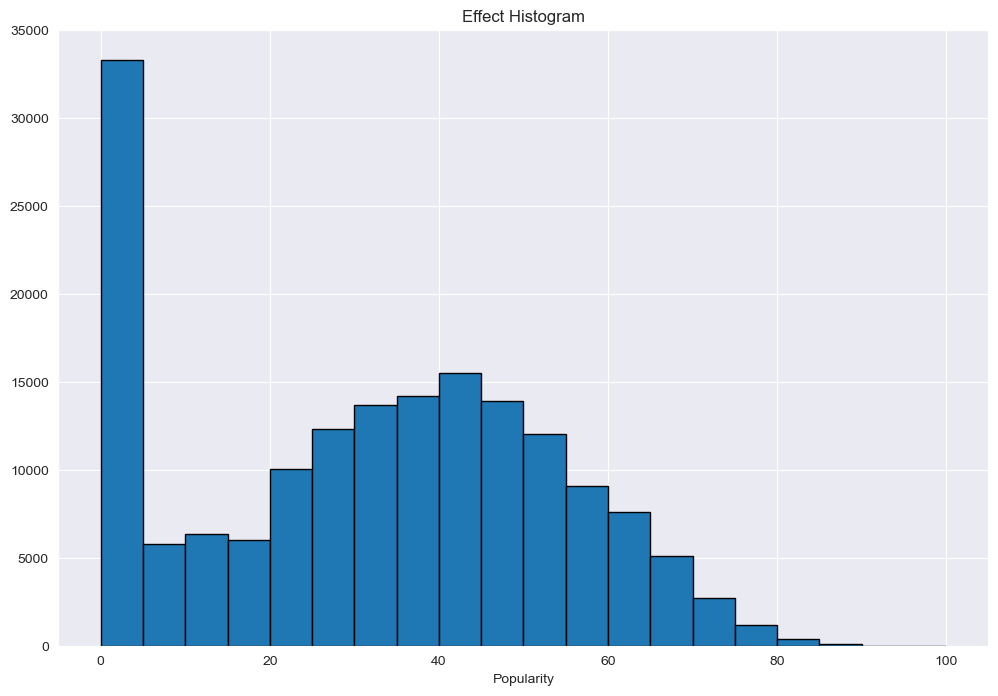

In [13]:
# plot histogram of effect column
_, ax = plt.subplots(figsize=(12, 8))
bins = list(range(0, 101, 5))
plt.hist(df.effect.values, bins=bins, edgecolor="k")
ax.set_xlabel('Popularity')
plt.xticks(rotation=0)
ax.title.set_text('Effect Histogram')
plt.show()

As we can see, there is a high value for 0-5, however, the distribution is still normal with median around 45-50
This sets the question, why are there so many records with popularity 0-5?
we will check in the next graph, whether it is because early years have lower popularity (due to unrecorded popularity maybe)

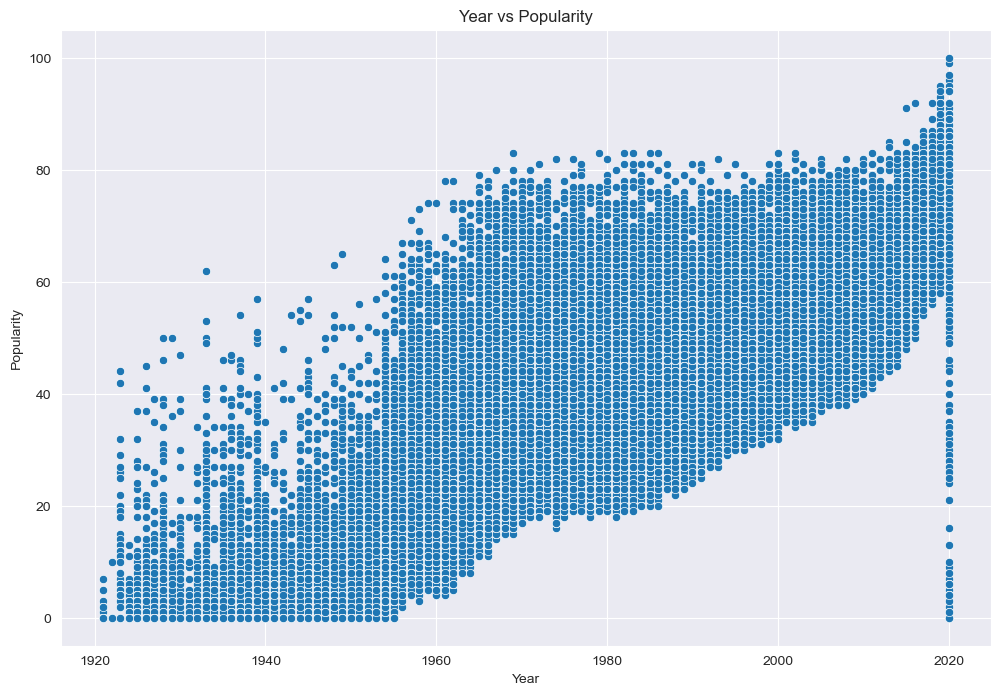

In [14]:
#  plot of year vs effect
_, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x='year', y='effect', data=df, ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Popularity')
ax.title.set_text('Year vs Popularity')
plt.show()

From the graph above, we can indeed see that the distribution of the popularity measure for years prior to 1950~1960 is is lower compared to later years. I.e., overall, songs from these years are less popular when cpmpared to songs later on. This result was indicated prevously, as we saw a positive correlation between the song's publishing year and the popularity. 

When considering the way Spotify generates it's popularity rating, we could obtain an explanation to phenomena described above. Spotify creates it's popularity rating mostly based on the total number of plays the track has had and how recent those plays are. Thus, the difference of the rating distribution could be explained by the fact that people nowadays simply don listen to song prior to 1950, as much as they listen to songs published after. 

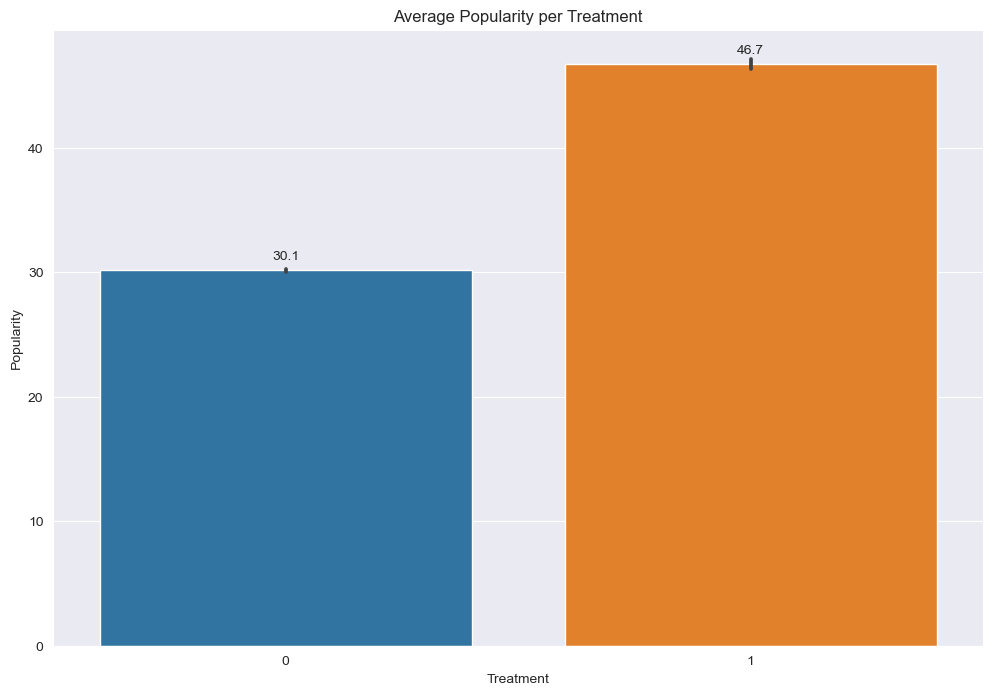

In [15]:
# plot average effect per treatment
_, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='treatment', y='effect', data=df, ax=ax)
ax.set_xlabel('Treatment')
ax.set_ylabel('Popularity')
ax.title.set_text('Average Popularity per Treatment')
# add values to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

Lastly, we can see that the average popularity is higher for explicit than for non-explicit, hence, we might indeed witness that the treatment affects the effect.

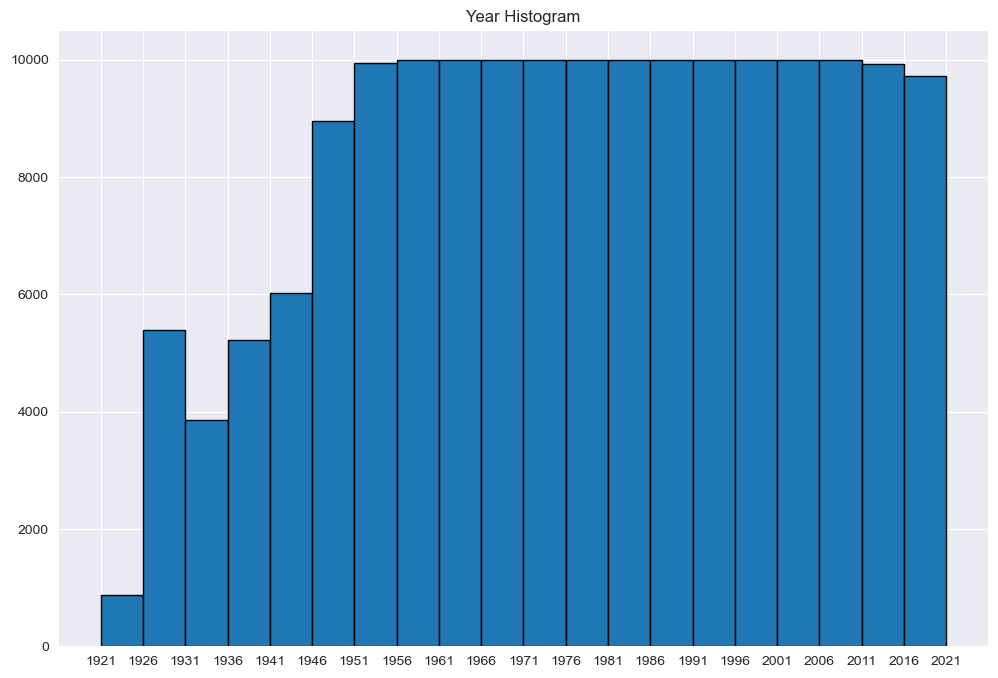

In [16]:
# plot histogram of year column
_, ax = plt.subplots(figsize=(12, 8))
bins = list(range(1921, 2022, 5))
plt.hist(df.year.values, bins=bins, edgecolor="k")
plt.xticks(bins)
ax.title.set_text('Year Histogram')
plt.show()

The amount of records per year is capped at 2,000 (data includes top 2000 songs of each year)
As we can see, early years have a lower number of records, and also the last 10 years has little less records (the difference is not significant)

The large difference between the 2000 recored value to the values of the yers prior to 1950 could be explained by the growth of music  streaming & listening platforms. The rise of record stores, personal consumption formats and most recently online streaming platforms, allowed for beter estimation of the popularity of songs.

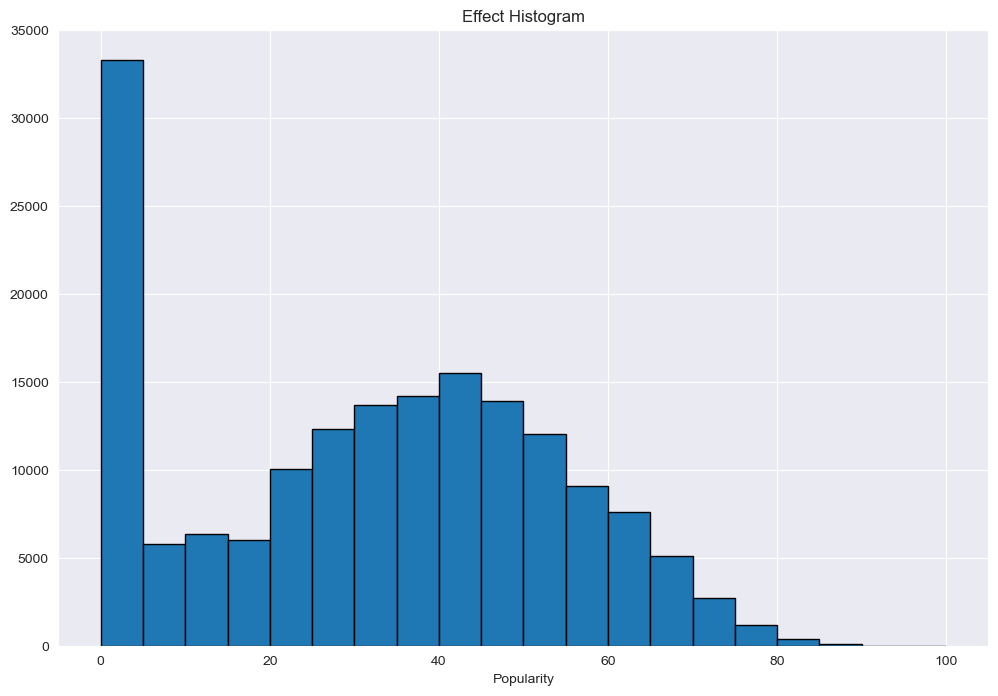

In [17]:
# plot histogram of effect column
_, ax = plt.subplots(figsize=(12, 8))
bins = list(range(0, 101, 5))
plt.hist(df.effect.values, bins=bins, edgecolor="k")
ax.set_xlabel('Popularity')
plt.xticks(rotation=0)
ax.title.set_text('Effect Histogram')
plt.show()

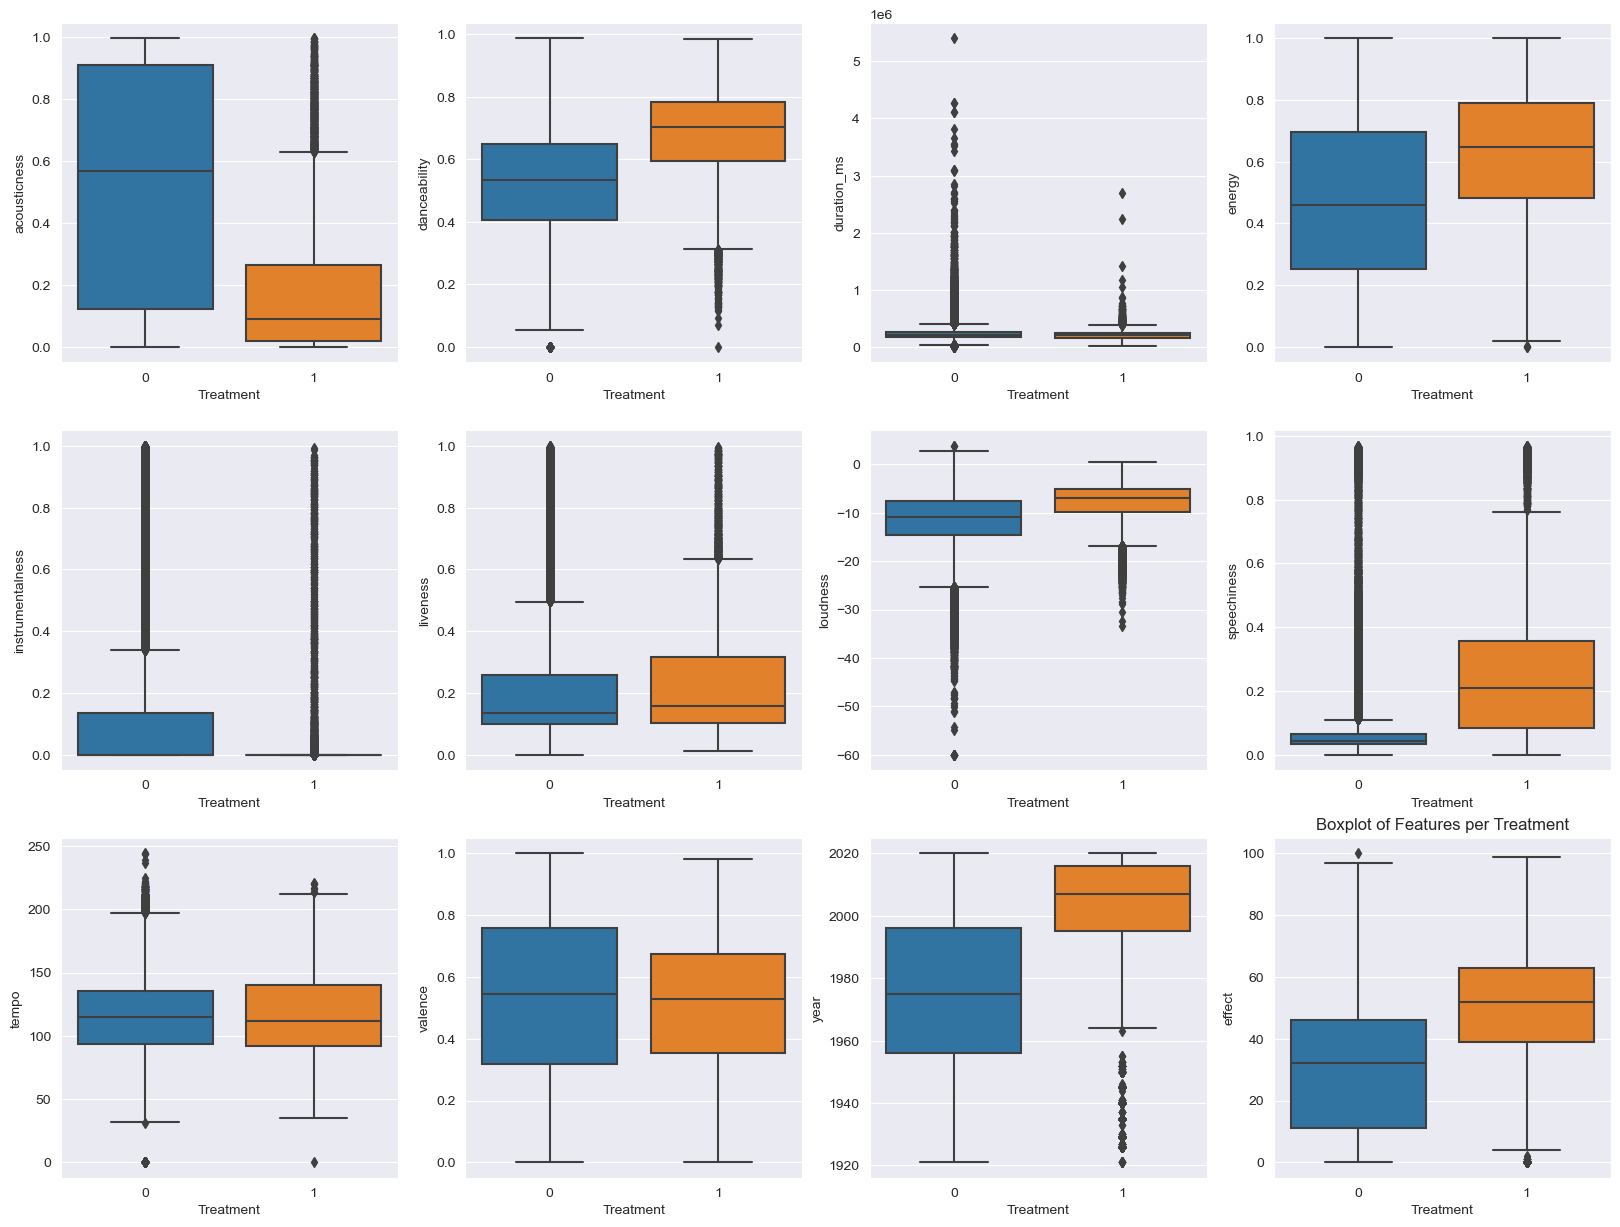

In [40]:
# plot a boxplot for each feature in both groups of treatment
_, axes = plt.subplots(3, 4, figsize=(20, 15))
for i, col in enumerate(df.columns[~df.columns.isin(['treatment', 'previous_artist_popularity', 'previous_artist_explicitness', 'mode', 'propensity_score', 'key'])]):
    ax = axes[i // 4, i % 4]
    sns.boxplot(x='treatment', y=col, data=df, ax=ax)
    ax.set_xlabel('Treatment')
    ax.set_ylabel(col)

ax.title.set_text('Boxplot of Features per Treatment')
plt.show()

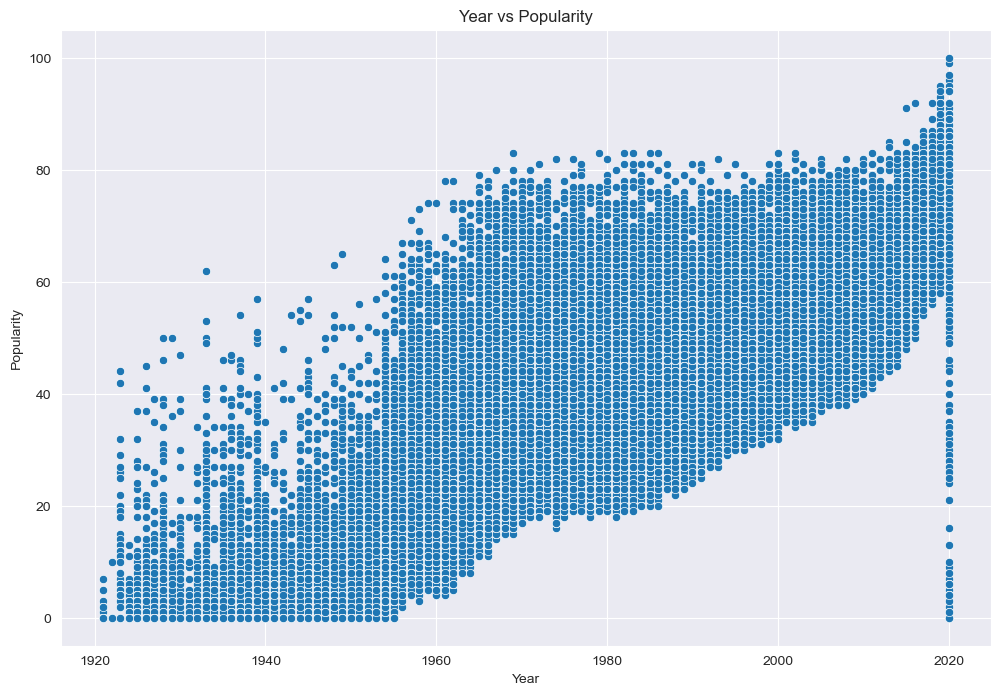

In [18]:
#  plot of year vs effect
_, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x='year', y='effect', data=df, ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Popularity')
ax.title.set_text('Year vs Popularity')
plt.show()

From the graph above, we can indeed see that the distribution of the popularity measure for years prior to 1950~1960 is is lower compared to later years. I.e., overall, songs from these years are less popular when cpmpared to songs later on. This result was indicated prevously, as we saw a positive correlation between the song's publishing year and the popularity. 

When considering the way Spotify generates it's popularity rating, we could obtain an explanation to phenomena described above. Spotify creates it's popularity rating mostly based on the total number of plays the track has had and how recent those plays are. Thus, the difference of the rating distribution could be explained by the fact that people nowadays simply don listen to song prior to 1950, as much as they listen to songs published after. 

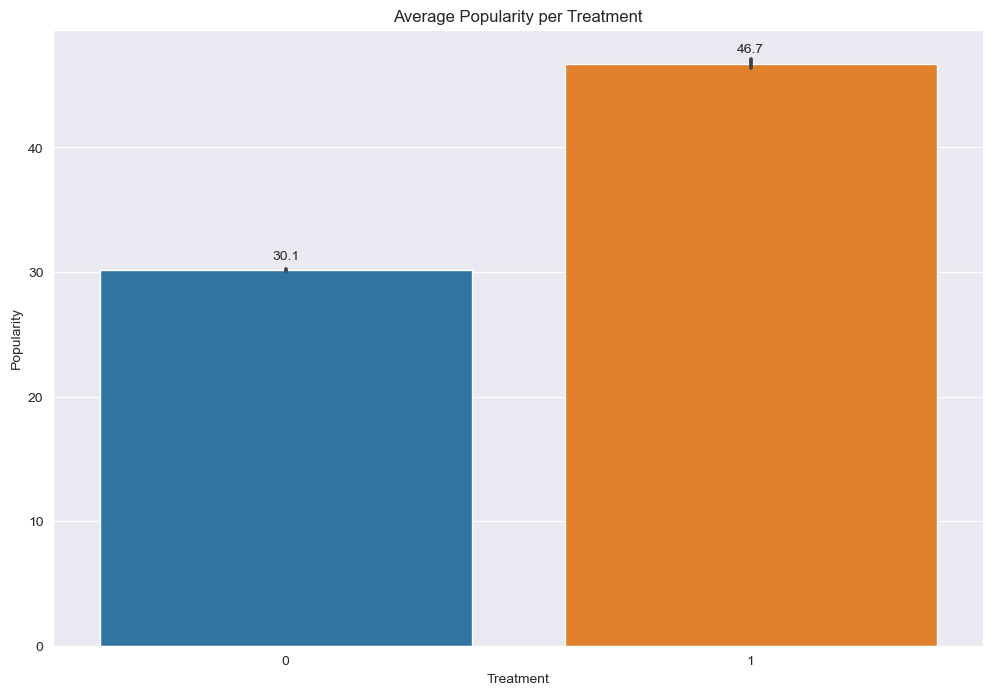

In [19]:
# plot average effect per treatment
_, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='treatment', y='effect', data=df, ax=ax)
ax.set_xlabel('Treatment')
ax.set_ylabel('Popularity')
ax.title.set_text('Average Popularity per Treatment')
# add values to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

Lastly, we can see that the average popularity is higher for explicit than for non-explicit, hence, we might indeed witness that the treatment affects the effect.

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def calculate_propensity_score(df):
    scaled = StandardScaler().fit_transform(df.drop(['effect', 'treatment'], axis=1))
    LR = LogisticRegression(random_state=0)
    LR.fit(scaled, df['treatment'])
    prop = LR.predict_proba(scaled)[:, 1]

    return prop

# calculate propensity score
df['propensity_score'] = calculate_propensity_score(df)

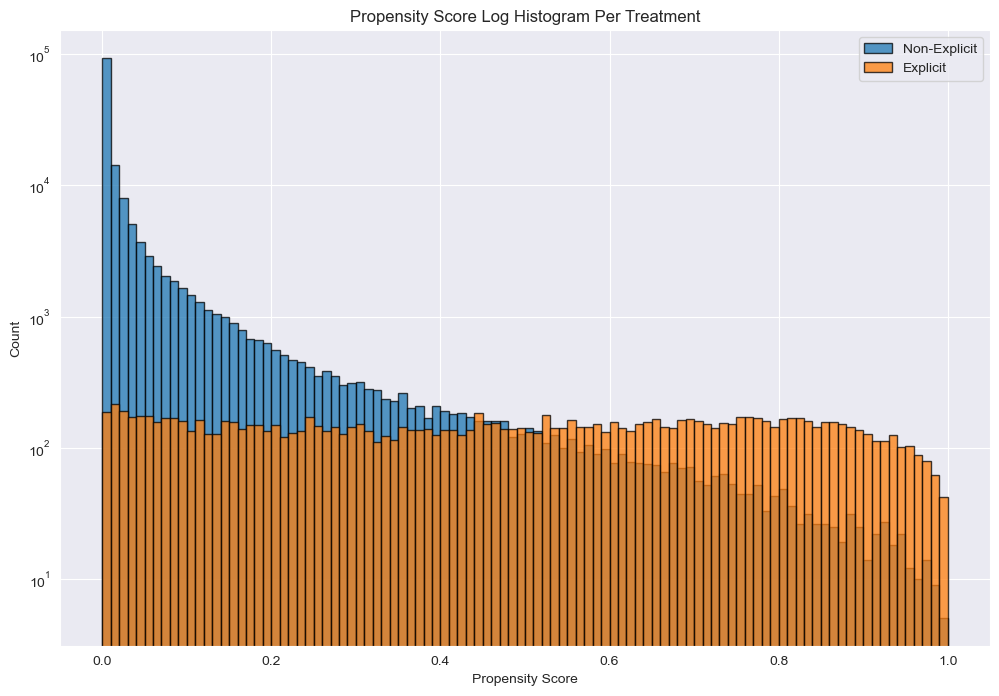

In [21]:
# plot propensity score histogram stacked by treatment, log scale
import numpy as np
_, ax = plt.subplots(figsize=(12, 8))
bins = np.arange(0, 1.01, 0.01)
plt.hist(df.propensity_score[df.treatment == 0].values, bins=bins, edgecolor="k", log=True, alpha=0.75, label='Non-Explicit')
plt.hist(df.propensity_score[df.treatment == 1].values, bins=bins, edgecolor="k", log=True, alpha=0.75, label='Explicit')
ax.set_xlabel('Propensity Score')
ax.set_ylabel('Count')
ax.title.set_text('Propensity Score Log Histogram Per Treatment')
ax.legend()
plt.show()

In [22]:
df.to_csv('data/final_data.csv', index=False)

In [23]:
df

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,year,previous_artist_explicitness,previous_artist_popularity,treatment,effect,propensity_score
78068,0.7320,0.819,180533,0.341,0.000000,7,0.1600,-12.441,1,0.4150,60.936,0.9630,1921,0.000000,0.000000,0,7,0.005415
78069,0.9820,0.279,831667,0.211,0.878000,10,0.6650,-20.096,1,0.0366,80.954,0.0594,1921,0.000000,7.000000,0,5,0.000009
78070,0.9410,0.241,196307,0.274,0.000008,0,0.0984,-9.750,0,0.0297,90.773,0.2120,1921,0.000000,6.000000,0,2,0.000089
78071,0.9570,0.418,166693,0.193,0.000002,3,0.2290,-10.096,1,0.0380,101.665,0.2530,1921,0.000000,4.666667,0,2,0.000148
78072,0.9960,0.518,159507,0.203,0.000000,0,0.1150,-10.589,1,0.0615,66.221,0.4060,1921,0.000000,4.000000,0,5,0.000171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169904,0.1730,0.875,163800,0.443,0.000032,1,0.0891,-7.461,1,0.1430,100.012,0.3060,2020,0.478514,64.578335,1,75,0.833833
169905,0.0167,0.719,167468,0.385,0.031300,8,0.1110,-10.907,1,0.0403,128.000,0.2700,2020,0.478514,64.580573,0,64,0.561083
169906,0.5380,0.514,180700,0.539,0.002330,7,0.1080,-9.332,1,0.1050,123.700,0.1530,2020,0.478514,64.576097,0,70,0.231453
169907,0.0714,0.646,167308,0.761,0.000000,1,0.2220,-2.557,1,0.0385,129.916,0.4720,2020,0.478514,64.575649,0,70,0.537738
